# Proyecto 01 - Parte 02
**Caso aplicativo**
El estudio “CineVision Studios” está complacido con lo que descubrió en el análisis exploratorio que su equipo le entregó. Sin embargo, le han surgido nuevas interrogantes. En la conformación de su equipo de Data Science, uno de los candidatos, en las entrevistas le ha comentado que existen algoritmos que permiten detectar patrones no evidentes en los datos que le proporcionó y “juntar” variables para que
sea más pequeño. Le ha pedido que indague un poco más en los datos y extraiga información interesante.

## Procesamiento

### Ingesta de datos

In [1]:
import sys
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import pyclustertend
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from mlxtend.frequent_patterns import apriori, association_rules
from apyori import apriori
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score, adjusted_rand_score
import scipy.cluster.hierarchy as sch
import re

file_path = "./movies.csv"
df = pd.read_csv(file_path, encoding="latin1")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   budget                     10000 non-null  int64  
 2   genres                     9947 non-null   object 
 3   homePage                   4193 non-null   object 
 4   productionCompany          9543 non-null   object 
 5   productionCompanyCountry   8720 non-null   object 
 6   productionCountry          9767 non-null   object 
 7   revenue                    10000 non-null  float64
 8   runtime                    10000 non-null  int64  
 9   video                      9514 non-null   object 
 10  director                   9926 non-null   object 
 11  actors                     9920 non-null   object 
 12  actorsPopularity           9913 non-null   object 
 13  actorsCharacter            9953 non-null   obje

### Normalización de datos

In [2]:

df = df.replace(r'^\s*$', np.nan, regex=True)

def clean_numeric(cell):
    if pd.isna(cell):
        return np.nan
    if isinstance(cell, str) and '|' in cell:
        cell = cell.split('|')[0]
    cell_clean = re.sub(r'[^0-9\.\-]', '', str(cell))
    try:
        return float(cell_clean)
    except:
        return np.nan

def is_numeric_column(series, threshold=0.8):
    non_null = series.dropna()
    if len(non_null) == 0:
        return False
    numeric_count = 0
    for val in non_null:
       
        if isinstance(val, str) and '|' in val:
            val = val.split('|')[0]
       
        val_clean = re.sub(r'[^0-9\.\-]', '', str(val))
        try:
            float(val_clean)
            numeric_count += 1
        except:
            pass
    return (numeric_count / len(non_null)) >= threshold

numeric_cols = [col for col in df.columns if is_numeric_column(df[col])]

for col in numeric_cols:
    df[col] = df[col].apply(clean_numeric)

def split_pipe(cell):
    if pd.isna(cell):
        return cell
    if isinstance(cell, str) and '|' in cell:
        return cell.split('|')
    return cell

non_numeric_cols = [col for col in df.columns if col not in numeric_cols]
for col in non_numeric_cols:
    df[col] = df[col].apply(split_pipe)

df.to_csv('data_clean.csv', index=False, encoding='utf-8')

### Selección de variables

In [3]:
numeric_columns = ["actorsPopularity", "castWomenAmount", "castMenAmount"]
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

features = [
    'popularity', 'budget', 'revenue', 'runtime', 'voteCount', 'voteAvg',
    'genresAmount', 'productionCoAmount', 'productionCountriesAmount',
    'actorsPopularity', 'actorsAmount', 'castWomenAmount', 'castMenAmount'
]

X = df[features].dropna()

scaler_global = StandardScaler()
X_scaled = scaler_global.fit_transform(X)

print("Forma de X_scaled:", X_scaled.shape)

df_scaled = pd.DataFrame(X_scaled, columns=features)
print("Vista previa de los datos globalmente estandarizados:")
print(df_scaled.head())

df_scaled.to_csv("movies_normalized.csv", index=False)

Forma de X_scaled: (9784, 13)
Vista previa de los datos globalmente estandarizados:
   popularity    budget   revenue   runtime  voteCount   voteAvg  \
0   -0.140011 -0.404818 -0.355605 -0.123225   0.273022 -0.828680   
1   -0.191588  0.055987 -0.303408  0.333830  -0.444273  0.010062   
2    0.221643 -0.215075  4.752680  0.752796   5.891057  1.792390   
3    0.379024  2.034738  5.845279 -0.047049   5.631840  1.373018   
4    0.033089  0.977597  4.103428  1.552642   7.998448  2.106918   

   genresAmount  productionCoAmount  productionCountriesAmount  \
0     -0.540547           -0.505237                  -0.248447   
1      0.342376           -0.063403                   0.084951   
2      0.342376           -0.505237                  -0.248447   
3     -0.540547           -0.947071                  -0.248447   
4      0.342376           -0.505237                  -0.248447   

   actorsPopularity  actorsAmount  castWomenAmount  castMenAmount  
0          0.679417     -0.124215        -

In [4]:
# Variables consideradas por análisis como relevantes agruparlas para su estudio
features_rendimiento = ['popularity', 'voteCount', 'voteAvg']
features_financiero  = ['budget', 'revenue']
features_produccion  = ['runtime', 'genresAmount', 'productionCoAmount', 'productionCountriesAmount']
features_reparto     = ['actorsPopularity', 'actorsAmount', 'castWomenAmount', 'castMenAmount']

def preparar_subconjunto(dataframe, features):
    data = dataframe[features].dropna()
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, scaler, data.index

data_rendimiento, scaler_rendimiento, indices_rendimiento = preparar_subconjunto(df, features_rendimiento)
data_financiero, scaler_financiero, indices_financiero   = preparar_subconjunto(df, features_financiero)
data_produccion, scaler_produccion, indices_produccion   = preparar_subconjunto(df, features_produccion)
data_reparto, scaler_reparto, indices_reparto             = preparar_subconjunto(df, features_reparto)


## Análsis de la tendencia de agrupamiento

### Estadístico de Hopkins y VAT (Grupo de variables y subgrupos)

#### Global

In [5]:
from sklearn.neighbors import NearestNeighbors

def hopkins(X):
    X = np.array(X)
    n, d = X.shape
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    rand_X = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (m, d))
    ujd = []
    wjd = []
    for j in range(m):
        u_dist, _ = nbrs.kneighbors([rand_X[j]], 2, return_distance=True)
        random_index = np.random.randint(0, n)
        w_dist, _ = nbrs.kneighbors([X[random_index]], 2, return_distance=True)
        ujd.append(u_dist[0][1])
        wjd.append(w_dist[0][1])
    H = np.sum(ujd) / (np.sum(ujd) + np.sum(wjd))
    return H

hopkins_global = hopkins(X_scaled)
print("Hopkins Global:", hopkins_global)


Hopkins Global: 0.9877622811696595


#### Subgrupos (Variables destacadas)

In [6]:
groups = {
    'Rendimiento': data_rendimiento,
    'Financiero': data_financiero,
    'Produccion': data_produccion,
    'Reparto': data_reparto
}

for name, data in groups.items():
    print(f"Hopkins {name}:", hopkins(data))

Hopkins Rendimiento: 0.9952519108065874
Hopkins Financiero: 0.9942586985459483
Hopkins Produccion: 0.9966365286897793
Hopkins Reparto: 0.9996602851411921


## Número Óptimo de Clústeres 

#### Global

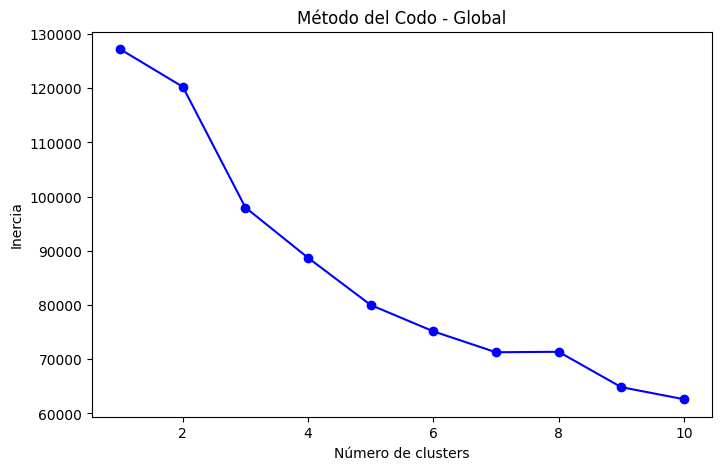

In [7]:
inertia_global = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia_global.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), inertia_global, 'bo-')
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.title("Método del Codo - Global")
plt.show()

#### Subgrupos (Variables destacadas)

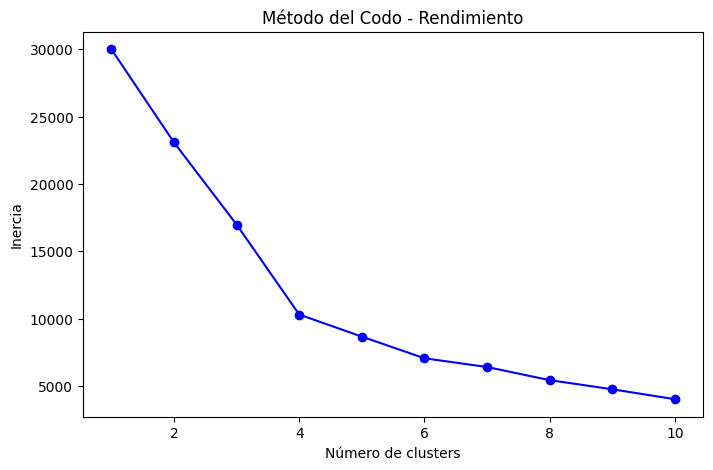

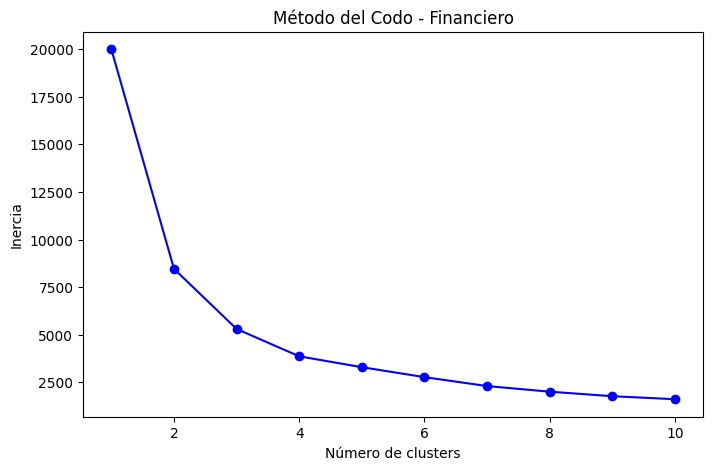

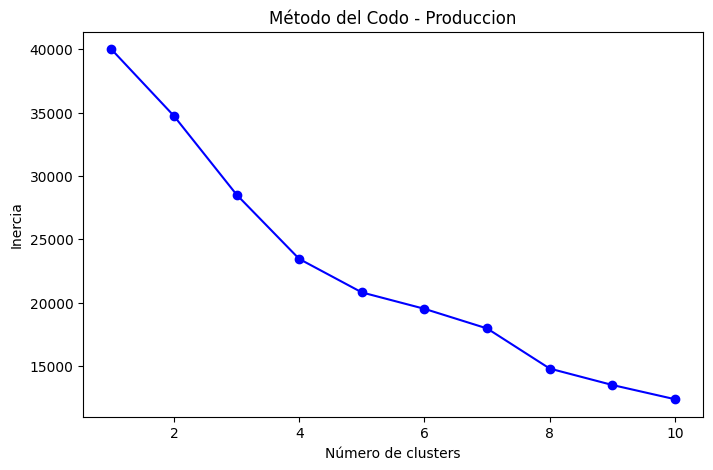

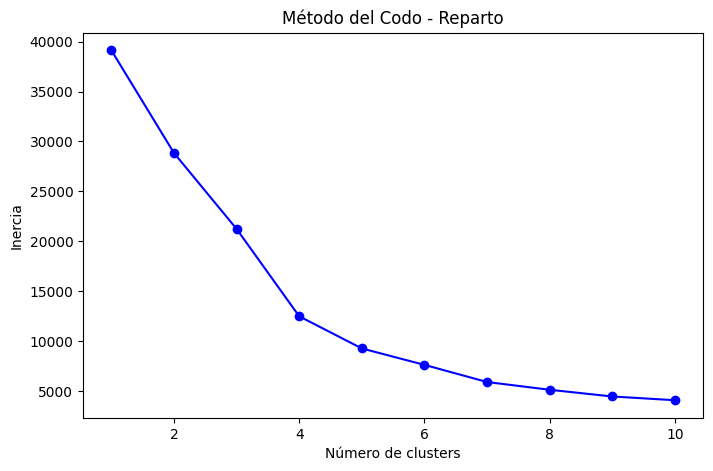

In [8]:
for name, data in groups.items():
    inertia_group = []
    for k in range(1, 11):
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(data)
        inertia_group.append(km.inertia_)
    plt.figure(figsize=(8,5))
    plt.plot(range(1, 11), inertia_group, 'bo-')
    plt.xlabel("Número de clusters")
    plt.ylabel("Inercia")
    plt.title(f"Método del Codo - {name}")
    plt.show()

## Clustering con K-Means y Clustering Jerárquico

#### Global

   Cluster_Global_KMeans  Cluster_Global_Agglo
0                    0.0                   1.0
1                    0.0                   1.0
2                    1.0                   0.0
3                    1.0                   0.0
4                    1.0                   0.0
5                    1.0                   0.0
6                    0.0                   0.0
7                    0.0                   1.0
8                    1.0                   0.0
9                    0.0                   0.0
Índice de Rand Ajustado (ARI) para clusters globales: 0.2515702965402331


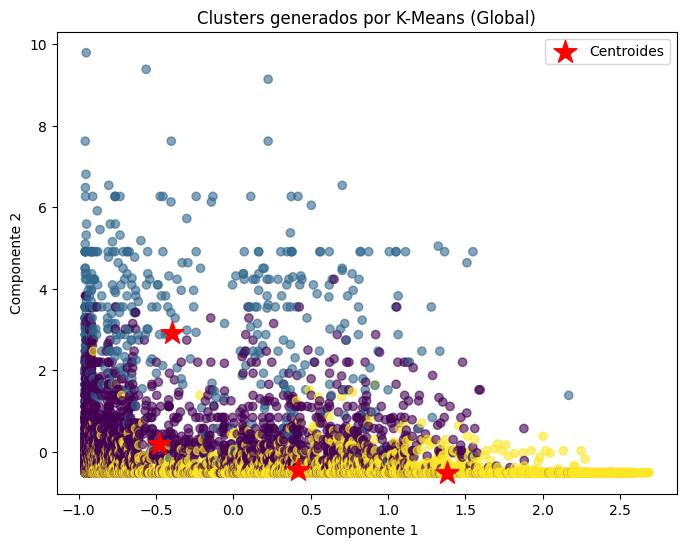

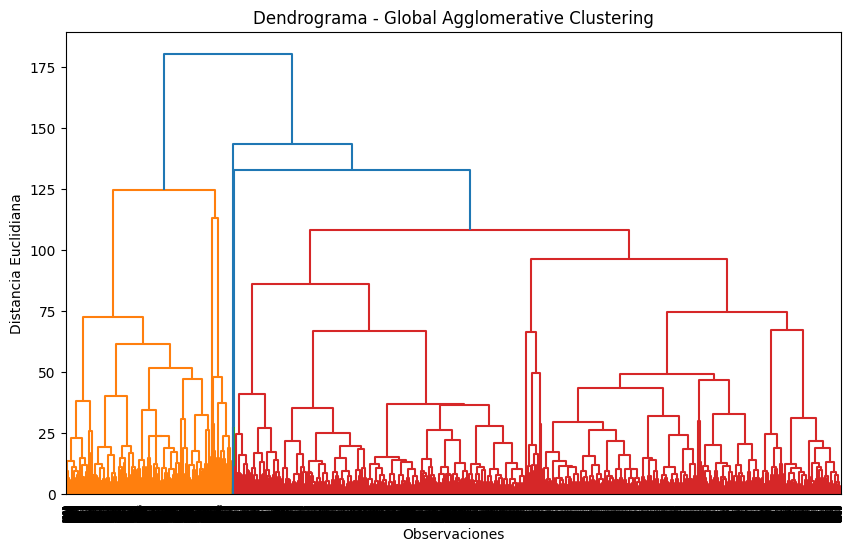

In [9]:
sys.setrecursionlimit(15000)

X_scaled_no_nan = X_scaled[~np.isnan(X_scaled).any(axis=1)]

optimal_k_global = 4

km_global = KMeans(n_clusters=optimal_k_global, random_state=42, n_init=10)
clusters_global = km_global.fit_predict(X_scaled_no_nan)

df.loc[X.index[:len(clusters_global)], 'Cluster_Global_KMeans'] = clusters_global

agglo_global = AgglomerativeClustering(n_clusters=optimal_k_global, linkage='ward')
clusters_global_agglo = agglo_global.fit_predict(X_scaled_no_nan)

df.loc[X.index[:len(clusters_global_agglo)], 'Cluster_Global_Agglo'] = clusters_global_agglo

print(df[['Cluster_Global_KMeans', 'Cluster_Global_Agglo']].head(10))

ari_global = adjusted_rand_score(df['Cluster_Global_KMeans'].dropna(), df['Cluster_Global_Agglo'].dropna())
print(f"Índice de Rand Ajustado (ARI) para clusters globales: {ari_global}")


plt.figure(figsize=(8,6))
plt.scatter(X_scaled_no_nan[:, 0], X_scaled_no_nan[:, 1], c=clusters_global, cmap='viridis', alpha=0.6)
plt.scatter(km_global.cluster_centers_[:, 0], km_global.cluster_centers_[:, 1], s=300, c='red', marker='*', label="Centroides")
plt.title("Clusters generados por K-Means (Global)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend()
plt.show()


def hierarchical_clustering(X, title):
    """Genera un dendrograma para representar la estructura de clustering jerárquico"""
    plt.figure(figsize=(10, 6))
    sch.dendrogram(sch.linkage(X, method='ward'))
    plt.title(f"Dendrograma - {title}")
    plt.xlabel("Observaciones")
    plt.ylabel("Distancia Euclidiana")
    plt.show()

hierarchical_clustering(X_scaled_no_nan, "Global Agglomerative Clustering")

#### Subgrupos (Variables destacadas)

Índice de Rand Ajustado (ARI) para el grupo Rendimiento: 0.6827163131343562
Índice de Rand Ajustado (ARI) para el grupo Financiero: 0.7334412921665332
Índice de Rand Ajustado (ARI) para el grupo Produccion: 0.4898810658889996
Índice de Rand Ajustado (ARI) para el grupo Reparto: 0.11974010920552827
   Cluster_Rendimiento_KMeans  Cluster_Rendimiento_Agglo  \
0                         1.0                        1.0   
1                         0.0                        0.0   
2                         2.0                        2.0   
3                         2.0                        2.0   
4                         2.0                        2.0   
5                         2.0                        2.0   
6                         0.0                        0.0   
7                         0.0                        0.0   
8                         2.0                        2.0   
9                         0.0                        0.0   

   Cluster_Financiero_KMeans  Cluster_Fi

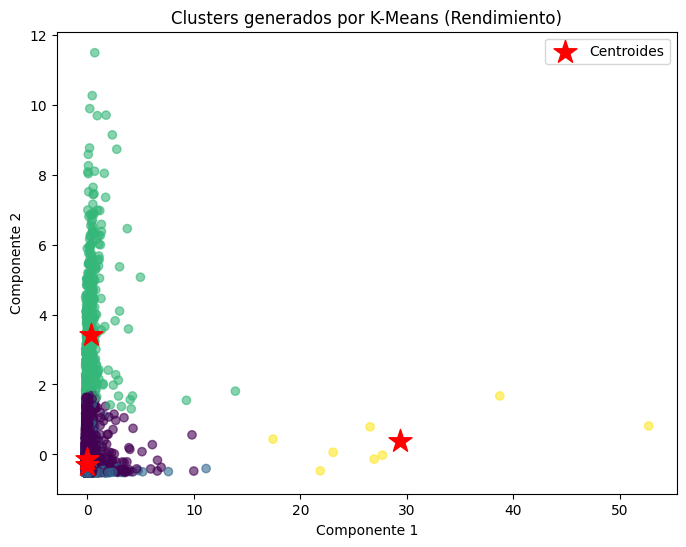

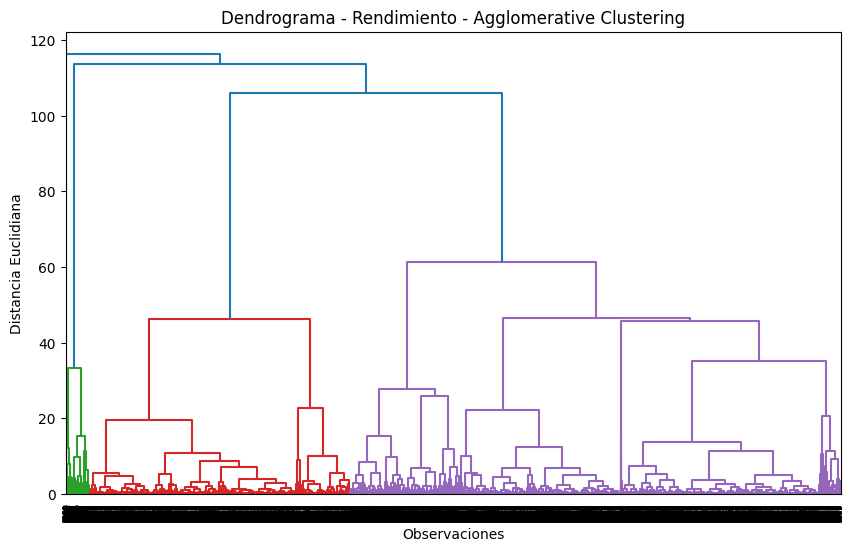

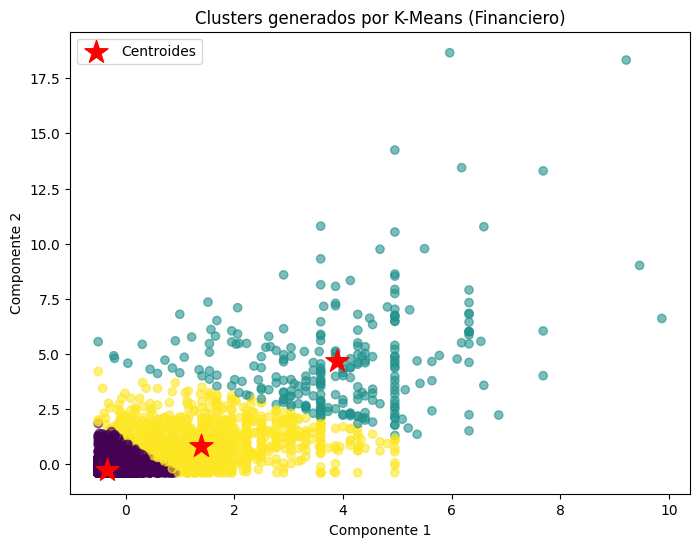

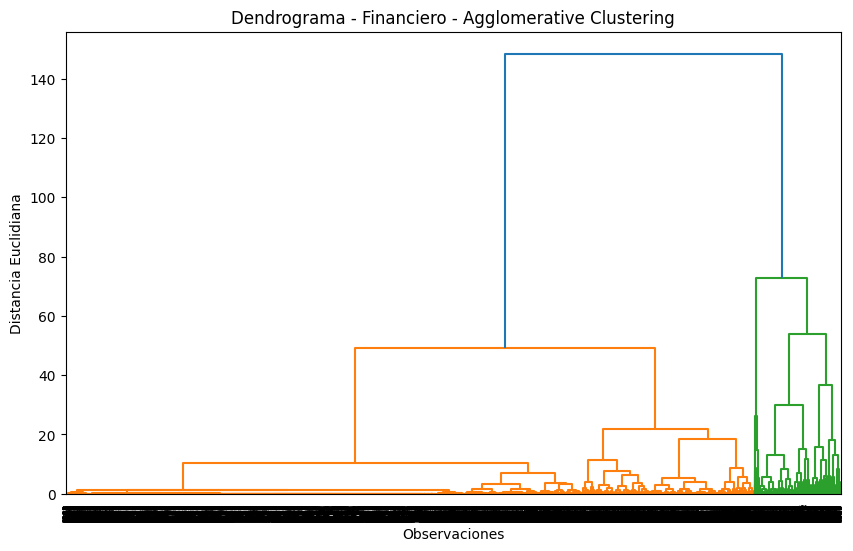

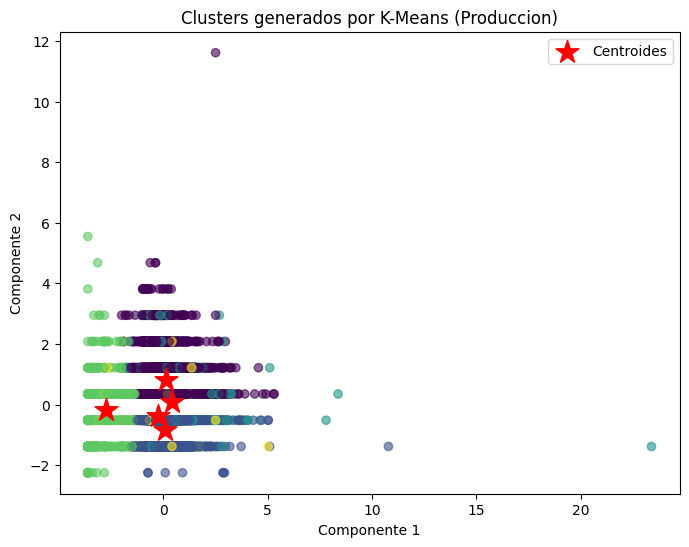

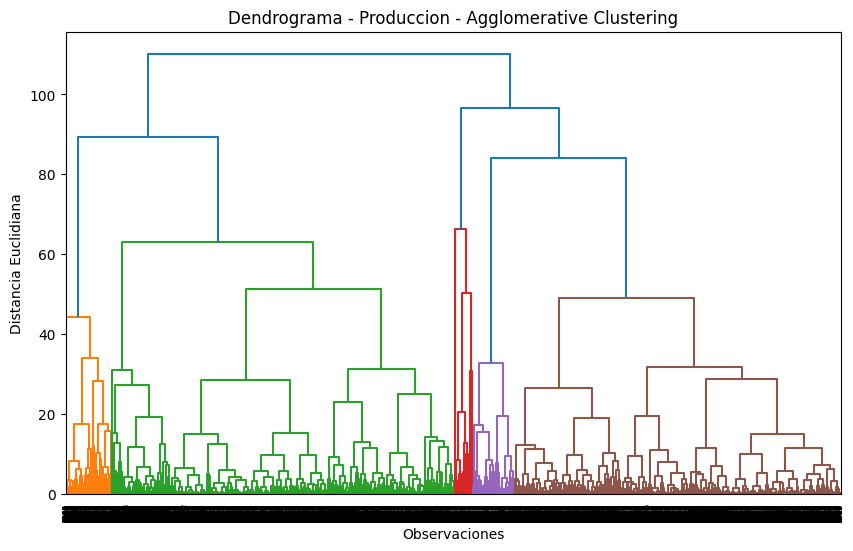

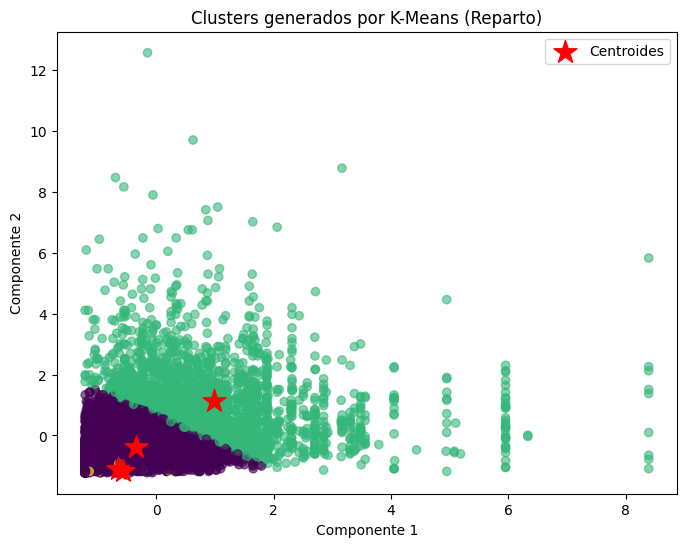

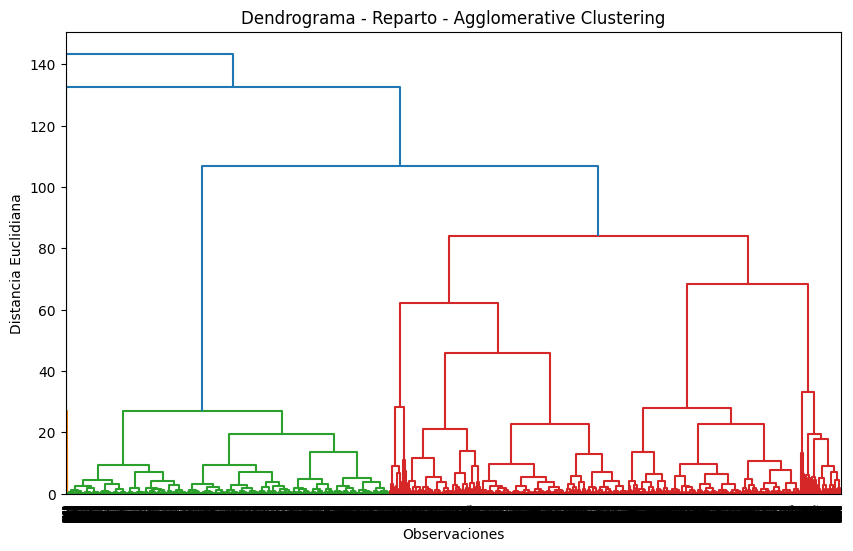

In [10]:
group_optimal = {
    'Rendimiento': 4,
    'Financiero': 3,
    'Produccion': 5,
    'Reparto': 4
}

for name, data in groups.items():
    k = group_optimal[name]
    
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = km.fit_predict(data)
    agglo = AgglomerativeClustering(n_clusters=k, linkage='ward')
    clusters_agglo = agglo.fit_predict(data)

    if name == 'Rendimiento':
        idx = indices_rendimiento
    elif name == 'Financiero':
        idx = indices_financiero
    elif name == 'Produccion':
        idx = indices_produccion
    elif name == 'Reparto':
        idx = indices_reparto

    df.loc[idx, f'Cluster_{name}_KMeans'] = clusters
    df.loc[idx, f'Cluster_{name}_Agglo'] = clusters_agglo

    # Cálculo del ARI para cada grupo
    ari_grupo = adjusted_rand_score(df.loc[idx, f'Cluster_{name}_KMeans'], df.loc[idx, f'Cluster_{name}_Agglo'])
    print(f"Índice de Rand Ajustado (ARI) para el grupo {name}: {ari_grupo}")


print(df[['Cluster_Rendimiento_KMeans', 'Cluster_Rendimiento_Agglo',
          'Cluster_Financiero_KMeans', 'Cluster_Financiero_Agglo',
          'Cluster_Produccion_KMeans', 'Cluster_Produccion_Agglo',
          'Cluster_Reparto_KMeans', 'Cluster_Reparto_Agglo']].head(10))


for name, data in groups.items():
    k = group_optimal[name]
    
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = km.fit_predict(data)
    
    plt.figure(figsize=(8,6))
    plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', alpha=0.6)
    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=300, c='red', marker='*', label="Centroides")
    plt.title(f"Clusters generados por K-Means ({name})")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.legend()
    plt.show()

    
    def hierarchical_clustering(X, title):
        """Genera un dendrograma para representar la estructura de clustering jerárquico"""
        plt.figure(figsize=(10, 6))
        sch.dendrogram(sch.linkage(X, method='ward'))
        plt.title(f"Dendrograma - {title}")
        plt.xlabel("Observaciones")
        plt.ylabel("Distancia Euclidiana")
        plt.show()

    hierarchical_clustering(data, f"{name} - Agglomerative Clustering")

## Evaluación de la Calidad del Agrupamiento (Silhouette Plot)

#### Global

For n_clusters = 4 Global silhouette score: 0.11537209198736101


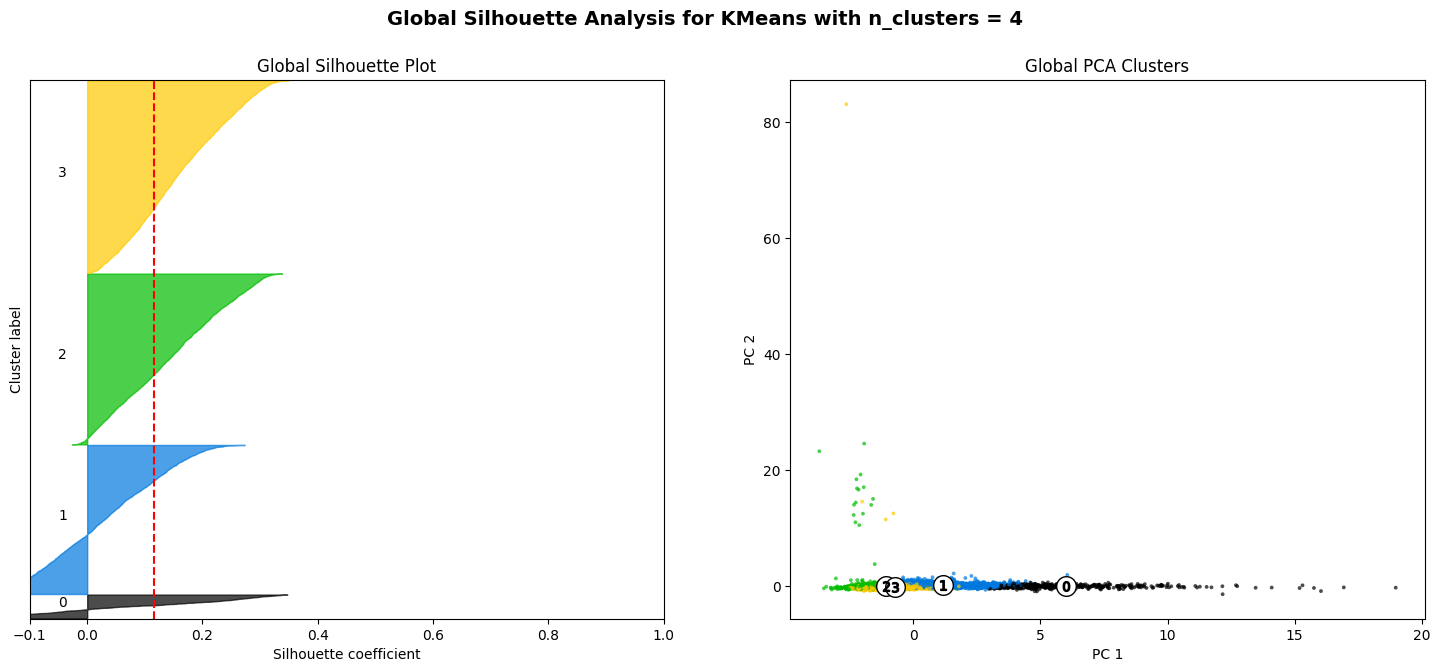

In [11]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [4]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, X_scaled.shape[0] + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters =", n_clusters, "Global silhouette score:", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_values = sample_silhouette_values[cluster_labels == i]
        ith_values.sort()
        size_i = ith_values.shape[0]
        y_upper = y_lower + size_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_i, str(i))
        y_lower = y_upper + 10
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_title("Global Silhouette Plot")
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7,
                c=colors, edgecolor="k")
    centers = clusterer.cluster_centers_
    centers_pca = pca.transform(centers)
    ax2.scatter(centers_pca[:, 0], centers_pca[:, 1], marker="o", c="white",
                alpha=1, s=200, edgecolor="k")
    for i, c in enumerate(centers_pca):
        ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")
    ax2.set_title("Global PCA Clusters")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")
    
    plt.suptitle("Global Silhouette Analysis for KMeans with n_clusters = %d" % n_clusters,
                 fontsize=14, fontweight="bold")
    plt.show()


Para n_clusters = 4 Global silhouette score (Agglo): 0.48989215205812786


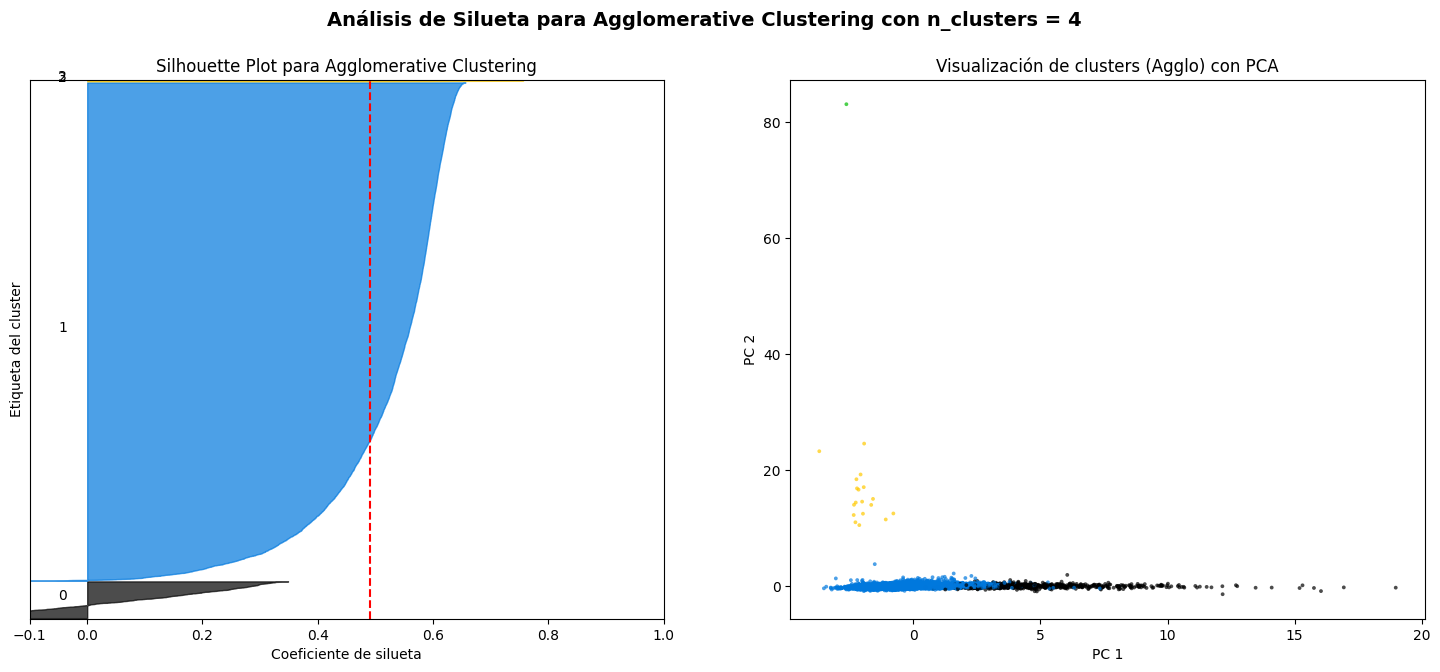

In [12]:
optimal_k = 4
cluster_labels = clusters_global_agglo

silhouette_avg = silhouette_score(X_scaled_no_nan, cluster_labels)
print("Para n_clusters =", optimal_k, "Global silhouette score (Agglo):", silhouette_avg)

sample_silhouette_values = silhouette_samples(X_scaled_no_nan, cluster_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, X_scaled_no_nan.shape[0] + (optimal_k + 1) * 10])

y_lower = 10
for i in range(optimal_k):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / optimal_k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_title("Silhouette Plot para Agglomerative Clustering")
ax1.set_xlabel("Coeficiente de silueta")
ax1.set_ylabel("Etiqueta del cluster")
ax1.set_yticks([])
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_no_nan)
colors = cm.nipy_spectral(cluster_labels.astype(float) / optimal_k)
ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7,
            c=colors, edgecolor="k")
ax2.set_title("Visualización de clusters (Agglo) con PCA")
ax2.set_xlabel("PC 1")
ax2.set_ylabel("PC 2")

plt.suptitle("Análisis de Silueta para Agglomerative Clustering con n_clusters = %d" % optimal_k,
             fontsize=14, fontweight="bold")
plt.show()


#### Subgrupos (Variables destacadas)

For Rendimiento with n_clusters = 4, silhouette score: 0.4182019444876601


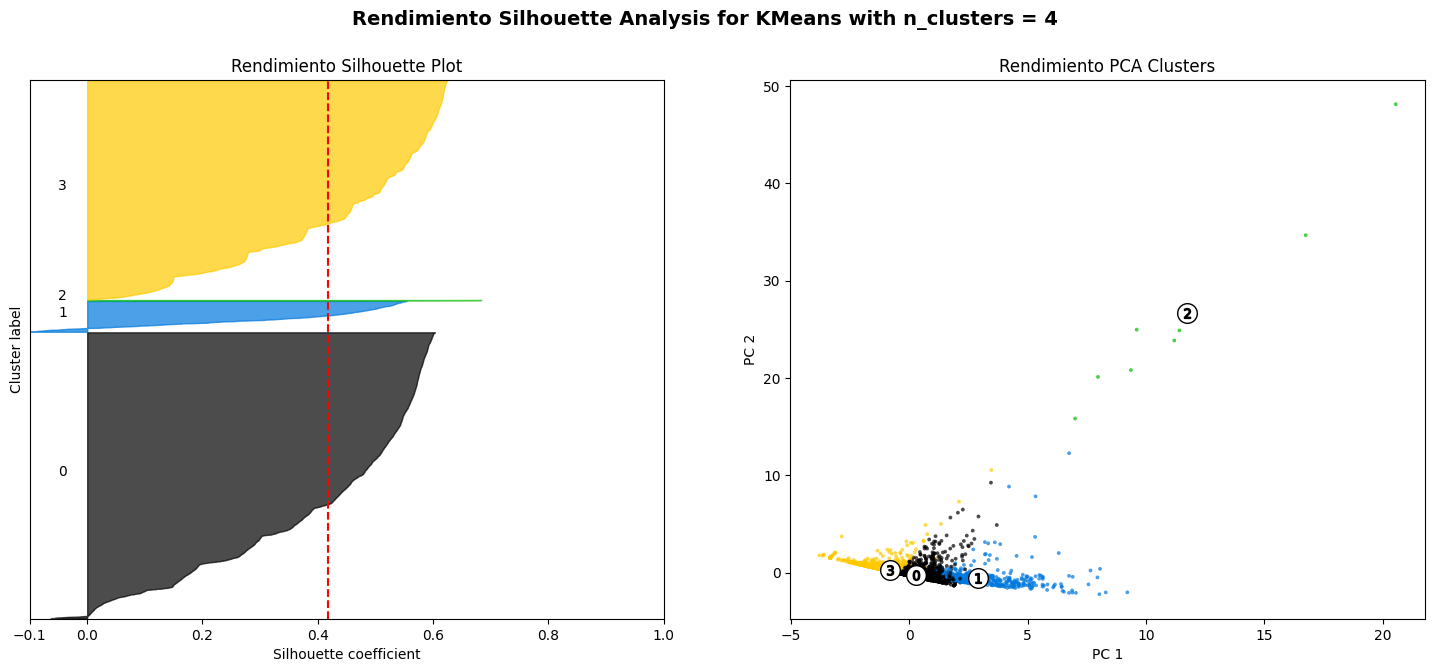

For Financiero with n_clusters = 3, silhouette score: 0.7396924943149752


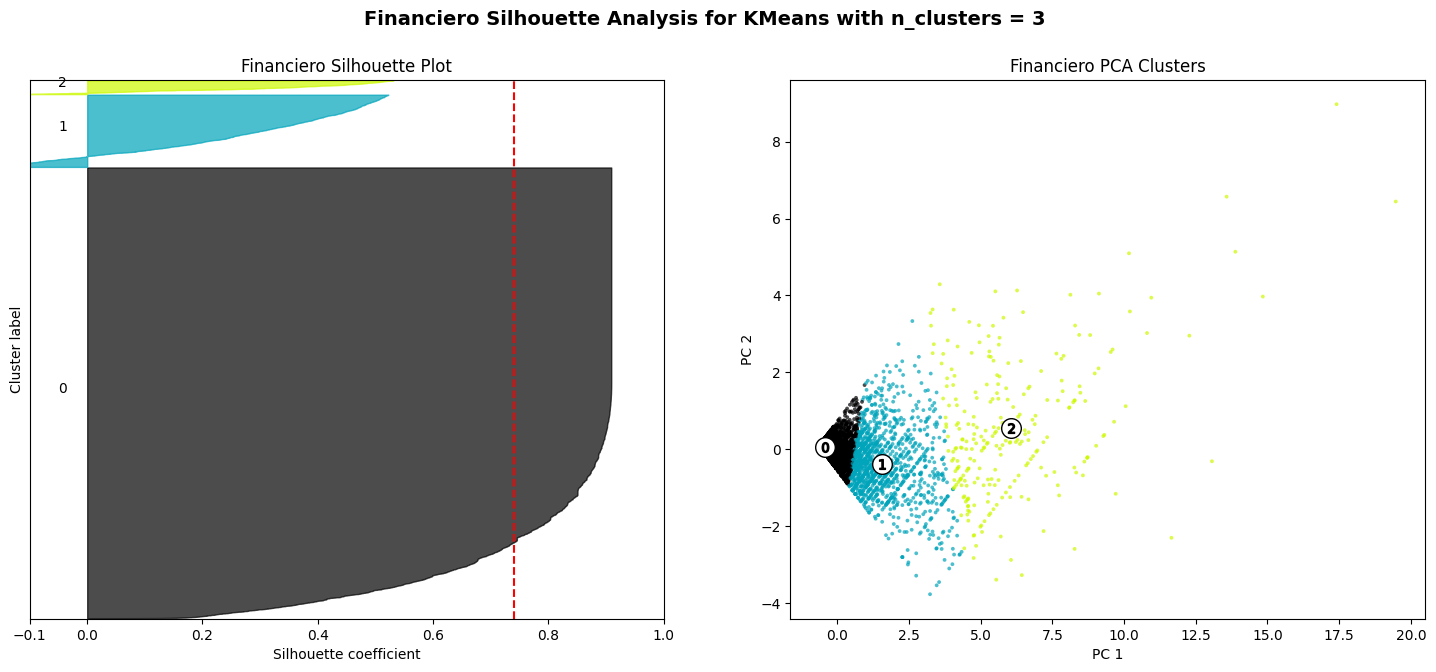

For Produccion with n_clusters = 5, silhouette score: 0.22669493947191255


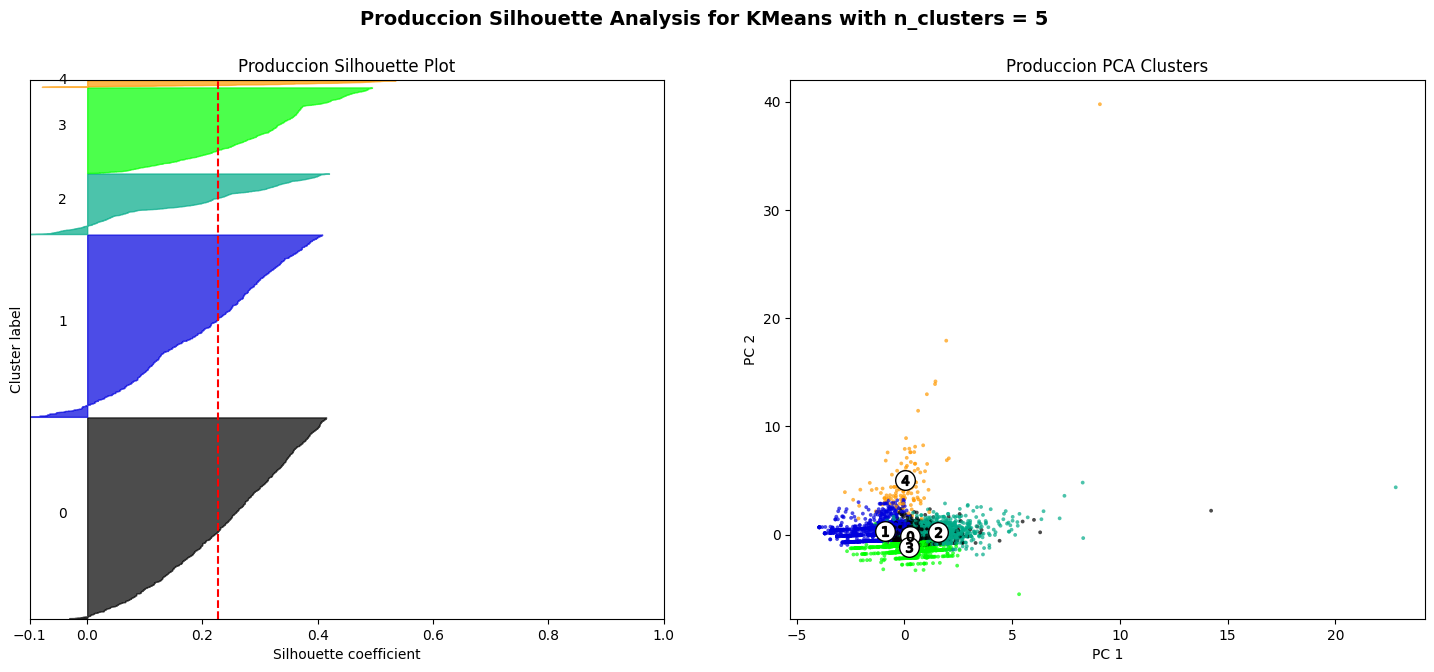

For Reparto with n_clusters = 4, silhouette score: 0.477818653599838


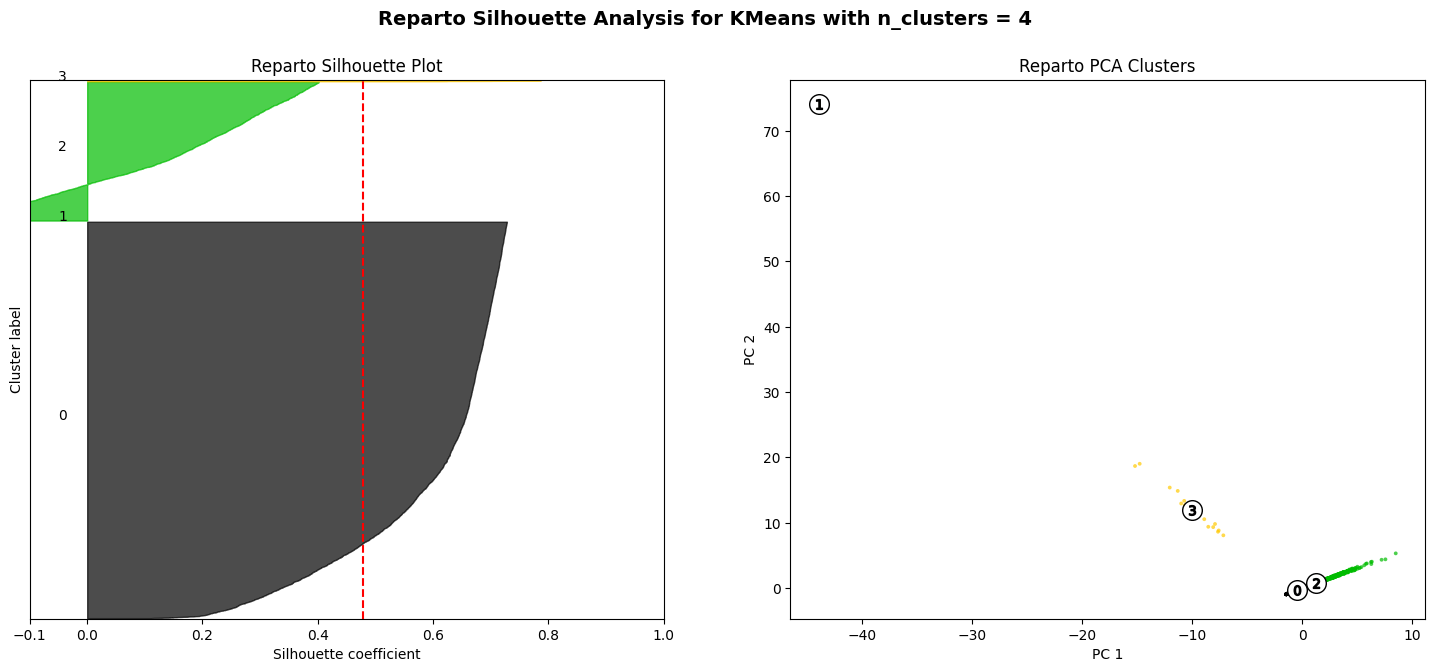

In [13]:
for name, data in groups.items():
    n_clusters = group_optimal[name]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, data.shape[0] + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    print(f"For {name} with n_clusters = {n_clusters}, silhouette score:", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_values = sample_silhouette_values[cluster_labels == i]
        ith_values.sort()
        size_i = ith_values.shape[0]
        y_upper = y_lower + size_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_i, str(i))
        y_lower = y_upper + 10
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_title(f"{name} Silhouette Plot")
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(data)
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7,
                c=colors, edgecolor="k")
    centers = clusterer.cluster_centers_
    centers_pca = pca.transform(centers)
    ax2.scatter(centers_pca[:, 0], centers_pca[:, 1], marker="o", c="white",
                alpha=1, s=200, edgecolor="k")
    for i, c in enumerate(centers_pca):
        ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")
    ax2.set_title(f"{name} PCA Clusters")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")
    
    plt.suptitle(f"{name} Silhouette Analysis for KMeans with n_clusters = {n_clusters}",
                 fontsize=14, fontweight="bold")
    plt.show()


For Rendimiento with n_clusters = 4, silhouette score (Agglo): 0.386537576471454


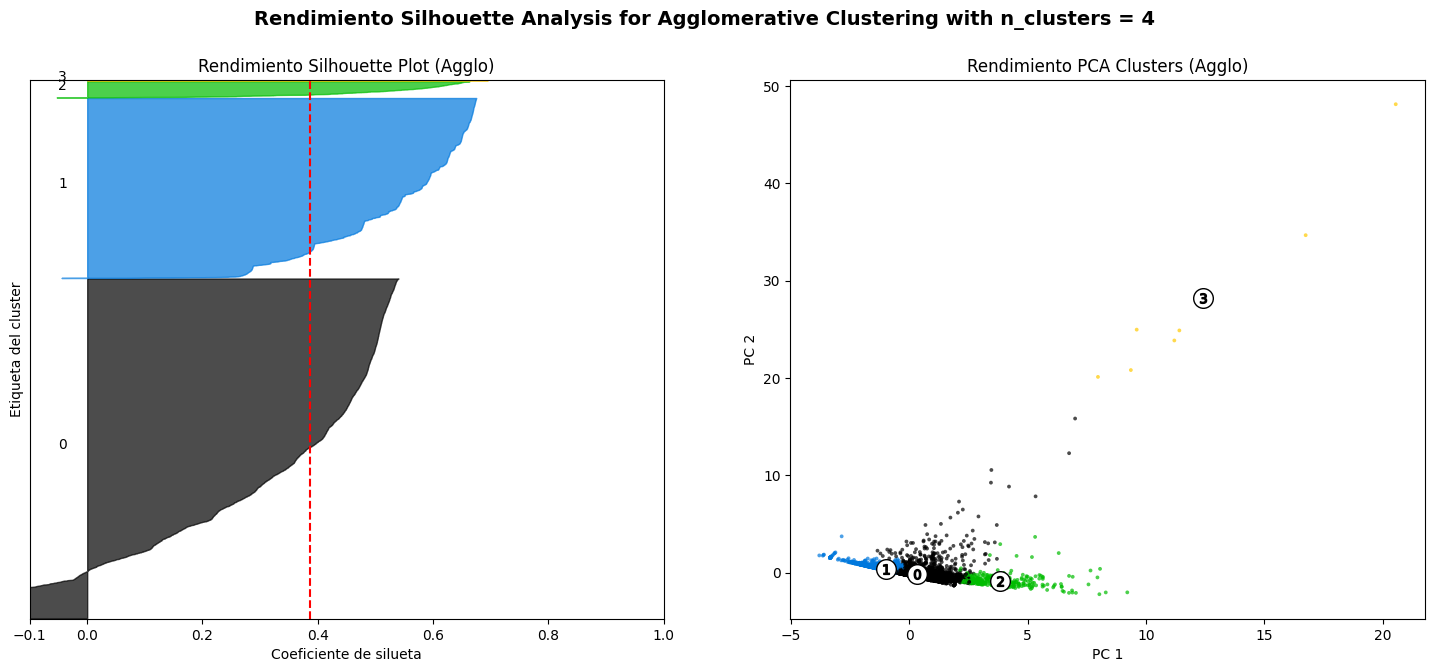

For Financiero with n_clusters = 3, silhouette score (Agglo): 0.7741180597944852


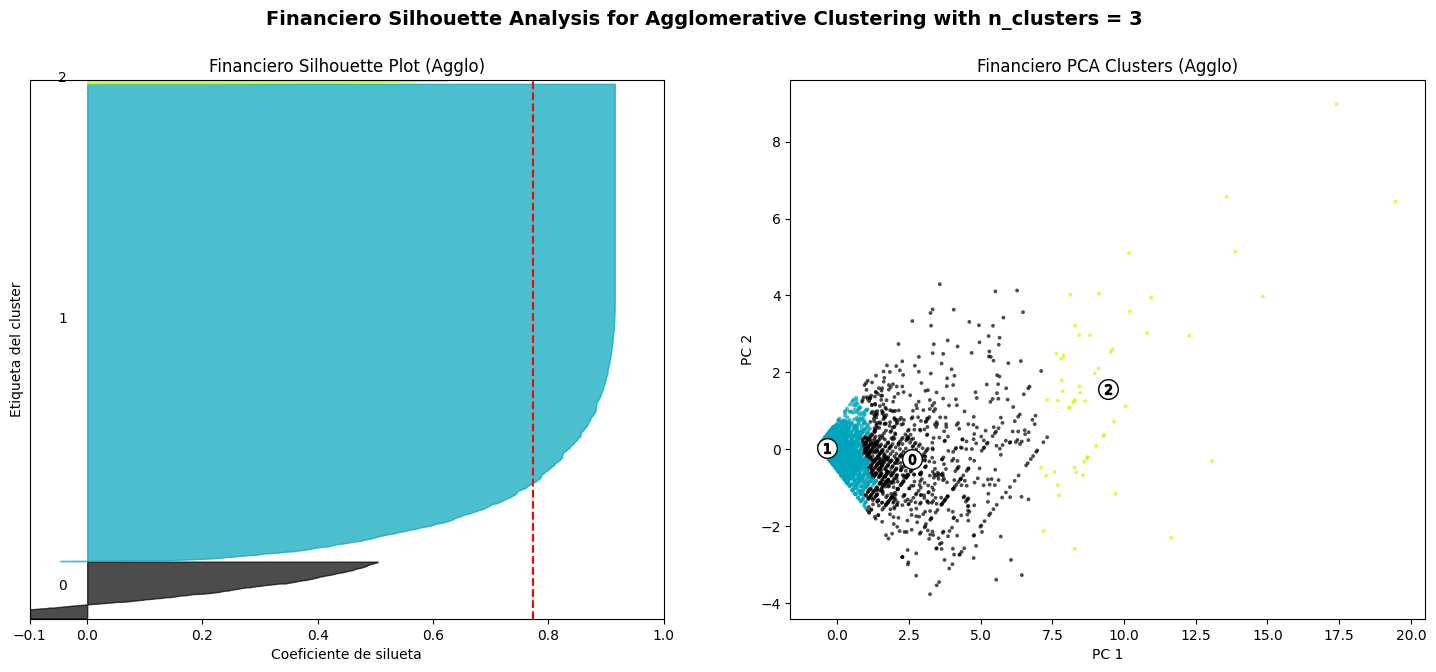

For Produccion with n_clusters = 5, silhouette score (Agglo): 0.2762901344677592


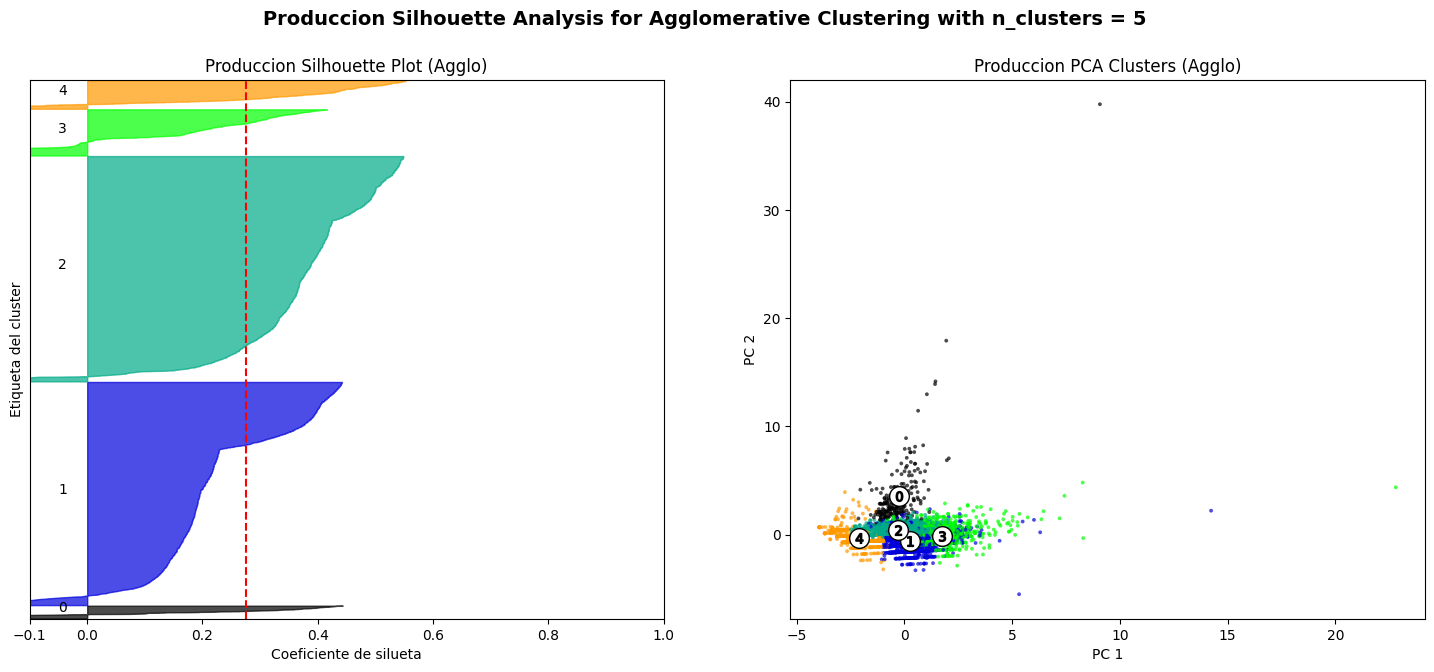

For Reparto with n_clusters = 4, silhouette score (Agglo): 0.2884604002800586


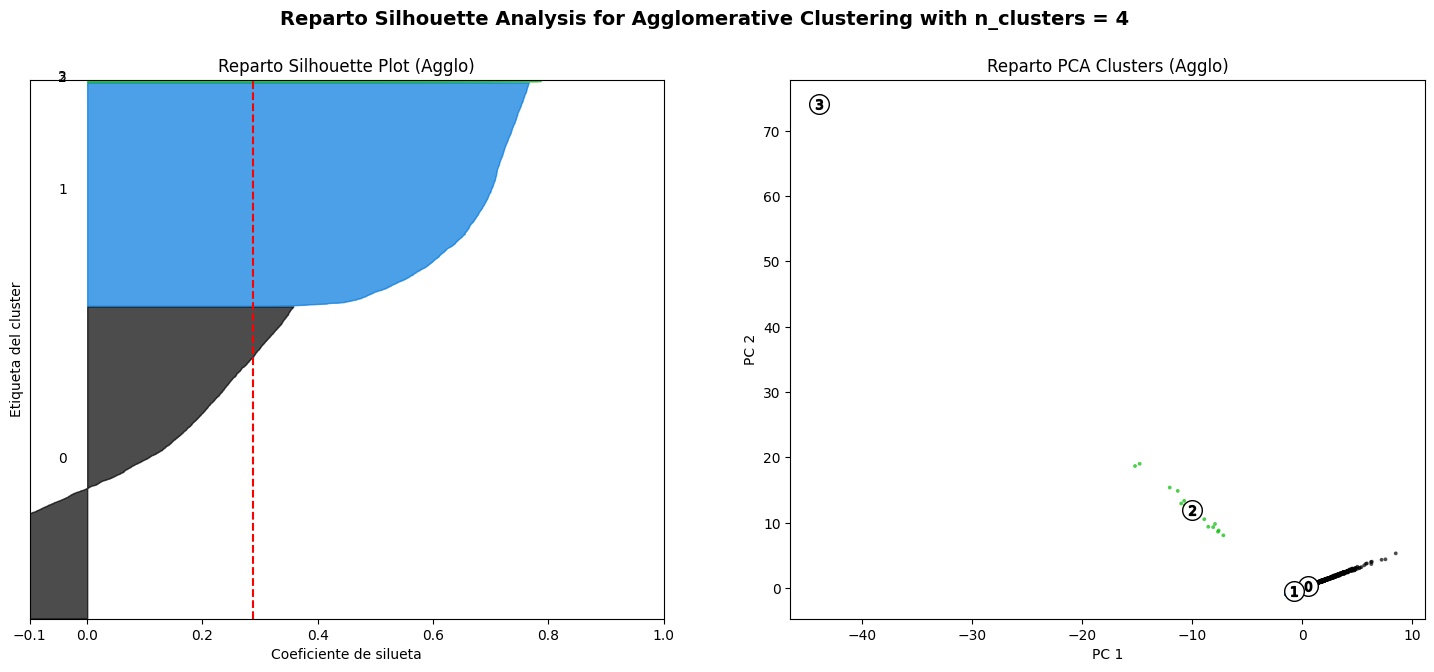

In [14]:
for name, data in groups.items():
    n_clusters = group_optimal[name]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, data.shape[0] + (n_clusters + 1) * 10])
    
    agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = agglo.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    print(f"For {name} with n_clusters = {n_clusters}, silhouette score (Agglo):", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_values = sample_silhouette_values[cluster_labels == i]
        ith_values.sort()
        size_i = ith_values.shape[0]
        y_upper = y_lower + size_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_i, str(i))
        y_lower = y_upper + 10
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_title(f"{name} Silhouette Plot (Agglo)")
    ax1.set_xlabel("Coeficiente de silueta")
    ax1.set_ylabel("Etiqueta del cluster")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(data)
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7,
                c=colors, edgecolor="k")
    
    centers = []
    for i in range(n_clusters):
        centers.append(data[cluster_labels == i].mean(axis=0))
    centers = np.vstack(centers)
    centers_pca = pca.transform(centers)
    
    ax2.scatter(centers_pca[:, 0], centers_pca[:, 1], marker="o", c="white",
                alpha=1, s=200, edgecolor="k")
    for i, c in enumerate(centers_pca):
        ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")
    
    ax2.set_title(f"{name} PCA Clusters (Agglo)")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")
    
    plt.suptitle(f"{name} Silhouette Analysis for Agglomerative Clustering with n_clusters = {n_clusters}",
                 fontsize=14, fontweight="bold")
    plt.show()


## PCA

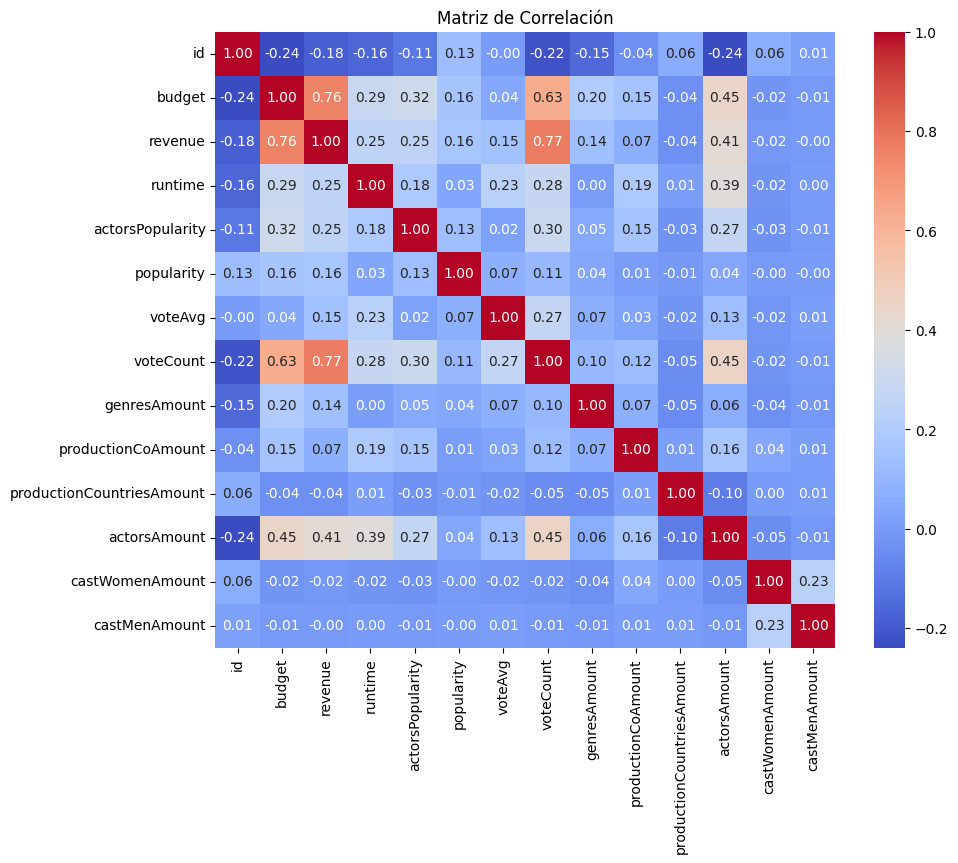

Índice KMO: 0.7600612908534091
Test de esfericidad de Bartlett: chi2 = 28541.533892631607 p-value = 0.0


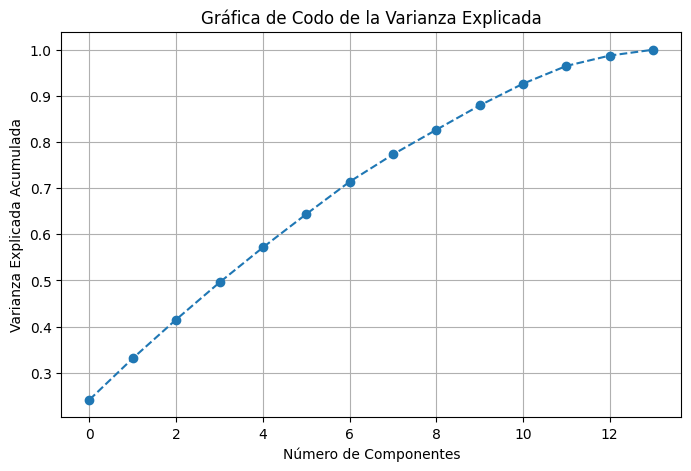

Número de componentes seleccionados para explicar al menos el 80% de la varianza: 9
Cargas (coeficientes) de los Componentes Principales:
                                PC1       PC2       PC3       PC4       PC5  \
id                        -0.195970  0.321198  0.459351  0.252124 -0.033175   
budget                     0.450115  0.022393  0.106686 -0.221049 -0.116639   
revenue                    0.453036  0.058252  0.197008 -0.193642  0.051727   
runtime                    0.277472  0.034441 -0.259526  0.486933  0.062487   
actorsPopularity           0.255506  0.051125  0.045124  0.059381 -0.431180   
popularity                 0.102522  0.235301  0.630488  0.045316 -0.086842   
voteAvg                    0.145934  0.083456  0.061180  0.444204  0.680840   
voteCount                  0.453331  0.050430  0.110890 -0.056682  0.125983   
genresAmount               0.123452 -0.184964 -0.029246 -0.378024  0.169131   
productionCoAmount         0.137817  0.123391 -0.296766  0.303796 -0.412

In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


file_path = "./data_clean.csv"
df = pd.read_csv(file_path, encoding="latin1")

numeric_cols = df.select_dtypes(include=[np.number]).columns
X = df[numeric_cols].dropna()  

corr_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

kmo_all, kmo_model = calculate_kmo(X)
print("Índice KMO:", kmo_model)

chi_square_value, p_value = calculate_bartlett_sphericity(X)
print("Test de esfericidad de Bartlett: chi2 =", chi_square_value, "p-value =", p_value)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Gráfica de Codo de la Varianza Explicada')
plt.grid(True)
plt.show()

n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.8) + 1
print("Número de componentes seleccionados para explicar al menos el 80% de la varianza:", n_components)

pca_final = PCA(n_components=n_components)
components_final = pca_final.fit_transform(X_scaled)

loadings = pd.DataFrame(pca_final.components_.T, 
                        columns=[f'PC{i+1}' for i in range(n_components)], 
                        index=numeric_cols)
print("Cargas (coeficientes) de los Componentes Principales:")
print(loadings)


## Reglas de asociación

In [16]:
file_path = "./movies.csv"
df = pd.read_csv(file_path, encoding="latin1")


df['genres_list'] = df['genres'].fillna("").apply(lambda x: x.split("|") if x != "" else [])


print("Ejemplo de géneros transformados:")
print(df[['genres', 'genres_list']].head())


transactions_genres = df['genres_list'].tolist()
transactions_genres = [t for t in transactions_genres if len(t) > 1]


print('Número total de transacciones con más de un género:', len(transactions_genres))
print('Ejemplo de transacción:', transactions_genres[0])


Ejemplo de géneros transformados:
                             genres                           genres_list
0                      Crime|Comedy                       [Crime, Comedy]
1             Action|Thriller|Crime             [Action, Thriller, Crime]
2  Adventure|Action|Science Fiction  [Adventure, Action, Science Fiction]
3                  Animation|Family                   [Animation, Family]
4              Comedy|Drama|Romance              [Comedy, Drama, Romance]
Número total de transacciones con más de un género: 8183
Ejemplo de transacción: ['Crime', 'Comedy']


#### Apriori a géneros

In [17]:
rules_genres = list(apriori(transactions_genres, min_support=0.05))


rules_list = []
for rule in rules_genres:
    for ordered_stat in rule.ordered_statistics:
        if ordered_stat.confidence >= 0.6 and ordered_stat.lift >= 1.2:
            rules_list.append({
                "antecedents": tuple(ordered_stat.items_base),
                "consequents": tuple(ordered_stat.items_add),
                "support": rule.support,
                "confidence": ordered_stat.confidence,
                "lift": ordered_stat.lift
            })


df_rules_genres = pd.DataFrame(rules_list).sort_values(by="lift", ascending=False)
print("Reglas de Asociación (Géneros):")
print(df_rules_genres.head(10))


Reglas de Asociación (Géneros):
           antecedents  consequents   support  confidence      lift
2  (Animation, Comedy)    (Family,)  0.051815    0.762590  4.466910
1           (Mystery,)  (Thriller,)  0.061469    0.627182  2.080353
0           (Romance,)     (Drama,)  0.106440    0.624373  1.563416


#### Géneros + Países de Producción

In [18]:
df['prodCountry_list'] = df['productionCountry'].fillna("").apply(lambda x: x.split("|") if x != "" else [])

df['combined_list'] = df['genres_list'] + df['prodCountry_list']

transactions_combined = df['combined_list'].tolist()
transactions_combined = [t for t in transactions_combined if len(t) > 1]

rules_combined = list(apriori(transactions_combined, min_support=0.05))

rules_list_combined = []
for rule in rules_combined:
    for ordered_stat in rule.ordered_statistics:
        if ordered_stat.confidence >= 0.6 and ordered_stat.lift >= 1.2:
            rules_list_combined.append({
                "antecedents": tuple(ordered_stat.items_base),
                "consequents": tuple(ordered_stat.items_add),
                "support": rule.support,
                "confidence": ordered_stat.confidence,
                "lift": ordered_stat.lift
            })

df_rules_combined = pd.DataFrame(rules_list_combined).sort_values(by="lift", ascending=False)
print("Reglas de Asociación Combinadas (Géneros + Países de Producción):")
print(df_rules_combined.head(10))


Reglas de Asociación Combinadas (Géneros + Países de Producción):
                             antecedents                  consequents  \
2  (Animation, United States of America)                    (Family,)   
1                             (Mystery,)                  (Thriller,)   
4     (United States of America, Family)                    (Comedy,)   
0                             (Romance,)                     (Drama,)   
3                       (Comedy, Family)  (United States of America,)   

    support  confidence      lift  
2  0.062652    0.764560  5.355183  
1  0.051076    0.626401  2.407805  
4  0.068034    0.608538  1.993639  
0  0.088444    0.613380  1.599727  
3  0.068034    0.848101  1.231147  


#### Géneros + Popularidad + Votación

In [19]:

file_path = "./movies.csv"
df = pd.read_csv(file_path, encoding="latin1")

if 'genres' not in df.columns or 'popularity' not in df.columns or 'voteAvg' not in df.columns:
    raise ValueError("El DataFrame debe contener las columnas 'genres', 'popularity' y 'voteAvg'.")

df['genres_list'] = df['genres'].fillna("").apply(lambda x: x.split("|") if x != "" else [])

if df['popularity'].nunique() < 3 or df['voteAvg'].nunique() < 3:
    raise ValueError("No hay suficientes valores únicos en 'popularity' o 'voteAvg' para aplicar pd.qcut")

df['popularity_category'] = pd.qcut(df['popularity'], q=3, labels=['Baja', 'Media', 'Alta'])
df['vote_category'] = pd.qcut(df['voteAvg'], q=3, labels=['Baja', 'Media', 'Alta'])

df['combined_list_2'] = (df['genres_list'] + 
                         df['popularity_category'].astype(str).apply(lambda x: [x]) + 
                         df['vote_category'].astype(str).apply(lambda x: [x]))

print("Ejemplo de transacción combinada:")
print(df['combined_list_2'].head())

transactions_pop_vote = df['combined_list_2'].tolist()
transactions_pop_vote = [t for t in transactions_pop_vote if len(t) > 1]

rules_pop_vote = list(apriori(transactions_pop_vote, min_support=0.05))

rules_list_pop_vote = []
for rule in rules_pop_vote:
    for ordered_stat in rule.ordered_statistics:
        if ordered_stat.confidence >= 0.6 and ordered_stat.lift >= 1.2:
            rules_list_pop_vote.append({
                "antecedents": tuple(ordered_stat.items_base),
                "consequents": tuple(ordered_stat.items_add),
                "support": rule.support,
                "confidence": ordered_stat.confidence,
                "lift": ordered_stat.lift
            })

df_rules_pop_vote = pd.DataFrame(rules_list_pop_vote).sort_values(by="confidence", ascending=False)
print("Reglas de Asociación Combinadas (Géneros + Popularidad + Votación):")
print(df_rules_pop_vote.head(10))


Ejemplo de transacción combinada:
0                        [Crime, Comedy, Media, Baja]
1              [Action, Thriller, Crime, Baja, Media]
2    [Adventure, Action, Science Fiction, Alta, Alta]
3                     [Animation, Family, Alta, Alta]
4                [Comedy, Drama, Romance, Alta, Alta]
Name: combined_list_2, dtype: object
Reglas de Asociación Combinadas (Géneros + Popularidad + Votación):
           antecedents   consequents  support  confidence      lift
0         (Animation,)       (Alta,)   0.1042    0.713699  1.330782
6   (Thriller, Horror)       (Baja,)   0.0518    0.692513  1.283145
1            (Horror,)       (Baja,)   0.1037    0.685847  1.270792
4       (Alta, Family)  (Animation,)   0.0541    0.665437  4.557785
5  (Animation, Family)       (Alta,)   0.0541    0.665437  1.240792
3           (Mystery,)   (Thriller,)   0.0503    0.626401  2.443062
7     (Media, Romance)      (Drama,)   0.0507    0.612319  1.616043
2           (Romance,)      (Drama,)   0.0871  

In [20]:
df_interesting = df_rules_combined[(df_rules_combined['lift'] > 1.5) & (df_rules_combined['confidence'] >= 0.6)]
print("Reglas más interesantes (Combinadas - Géneros + Países) con lift > 1.5 y confianza >= 0.6:")
print(df_interesting.head(10))

Reglas más interesantes (Combinadas - Géneros + Países) con lift > 1.5 y confianza >= 0.6:
                             antecedents  consequents   support  confidence  \
2  (Animation, United States of America)    (Family,)  0.062652    0.764560   
1                             (Mystery,)  (Thriller,)  0.051076    0.626401   
4     (United States of America, Family)    (Comedy,)  0.068034    0.608538   
0                             (Romance,)     (Drama,)  0.088444    0.613380   

       lift  
2  5.355183  
1  2.407805  
4  1.993639  
0  1.599727  
